In [1]:
import numpy as np

import pandas as pd

import scipy
import scipy.sparse as sp

import tensorflow as tf

class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

#ISM code

def _ism(predictor, x, seq_start=0, seq_end=100, n_out=1) :
    
    perturb_scores = np.zeros((n_out, x.shape[0], seq_end-seq_start, x.shape[2]))

    y_hat_ref = predictor.predict([x], batch_size=32)

    for data_ix in range(x.shape[0]) :

        x_curr = x[data_ix, :, :]
        x_var = np.zeros(((seq_end-seq_start) * x_curr.shape[1], x_curr.shape[0], x_curr.shape[1]))

        x_var[:, :, :] = x_curr[:, :]

        for j in range(seq_end-seq_start) :
            for k in range(x.shape[2]) :
                x_var[j * x.shape[2] + k, (seq_start + j), :] = 0.
                x_var[j * x.shape[2] + k, (seq_start + j), k] = 1.

        y_hat_var = predictor.predict([x_var], batch_size=32)

        for j in range(seq_end-seq_start) :
            for k in range(x.shape[2]) :
                perturb_scores[:, data_ix, j, k] = y_hat_var[j * x.shape[2] + k, :] - y_hat_ref[data_ix, :]
        
    importance_scores = np.tile(np.mean(perturb_scores, axis=-1, keepdims=True), (1, 1, 1, x.shape[2]))
    
    return importance_scores, perturb_scores

def _ism_aparent(predictor, x, l, d, seq_start=0, seq_end=100, n_out=1) :
    
    perturb_scores = np.zeros((n_out, x.shape[0], seq_end-seq_start, x.shape[2]))

    y_hat_ref = predictor.predict([x, l, d], batch_size=32)

    for data_ix in range(x.shape[0]) :

        x_curr = x[data_ix, :, :]
        x_var = np.zeros(((seq_end-seq_start) * x_curr.shape[1], x_curr.shape[0], x_curr.shape[1]))

        x_var[:, :, :] = x_curr[:, :]

        for j in range(seq_end-seq_start) :
            for k in range(x.shape[2]) :
                x_var[j * x.shape[2] + k, (seq_start + j), :] = 0.
                x_var[j * x.shape[2] + k, (seq_start + j), k] = 1.

        y_hat_var = predictor.predict([x_var, np.tile(l, (x_var.shape[0], 1)), np.tile(d, (x_var.shape[0], 1))], batch_size=32)

        for j in range(seq_end-seq_start) :
            for k in range(x.shape[2]) :
                perturb_scores[:, data_ix, j, k] = y_hat_var[j * x.shape[2] + k, :] - y_hat_ref[data_ix, :]
        
    importance_scores = np.tile(np.mean(perturb_scores, axis=-1, keepdims=True), (1, 1, 1, x.shape[2]))
    
    return importance_scores, perturb_scores

#Sequence logo visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_dna_logo(pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164, plot_sequence_template=False, save_figs=False, fig_name=None) :

    #Slice according to seq trim index
    pwm = np.copy(pwm[plot_start: plot_end, :])
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    ax = plt.gca()

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != '$' :
                color = 'black'
                if plot_sequence_template and nt == sequence_template[j] :
                    nt_prob = 2.0
                else :
                    nt_prob = 0.0

            if ii == 0 :
                dna_letter_at(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                dna_letter_at(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    plt.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)

    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, score_norm=False, sequence_template='', plot_start=0, plot_end=96, save_figs=False, fig_name=None) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    if score_norm :
        importance_scores / np.max(np.abs(importance_scores))
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")
    
    plt.show()
'''
#Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
'''

"\n#Limit GPU memory growth\ngpus = tf.config.experimental.list_physical_devices('GPU')\nfor gpu in gpus:\n    tf.config.experimental.set_memory_growth(gpu, True)\n"

In [2]:

df = pd.read_csv("isoform_merged_utr3_only_iso_lead_SNPs.csv", sep='\t')


In [3]:
#utr5 and orf From Sabeti_testSet/pmirGLO_construct.txt
utr5 = "GACAGCACCGCTGAGCAATGGAAGCGGGTAGGCCTTTGGGGCAGCGGCCAATAGCAGCTTTGCTCCTTCGCTTTCTGGGCTCAGAGGCTGGGAAGGGGTGGGTCCGGGGGCGGGCTCAGGGGCGGGCTCAGGGGCGGGGCGGGCGCCCGAAGGTCCTCCGGAGGCCCGGCATTCTGCACGCTTCAAAAGCGCACGTCTGCCGCGCTGTTCTCCTCTTCCTCATCTCCGGGCCTTTCGACCTGCAGCCCAAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACC"
orf = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCTTCACCTACGGCGTGCAGTGCTTCGCCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAAGGTCTATATCACCGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGACCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAA"


In [4]:
#Load saluki model

import os, sys
import argparse, json, h5py, time

from basenji import dna_io

try:
    import rnann
except:
    from basenji import rnann

encode_batch_size = 4800
predict_batch_size = 64
MAXLEN = 12288

f = 0
c = 0

params_file = "datasets/deeplearning/train_gru/params.json"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_model = params['model']
params_train = params['train']

aa_len = int(len(orf)/3)
coding = np.append(np.zeros(len(utr5)), np.tile([1,0,0], aa_len))

print('f' + str(f) + '_c' + str(c))
        
model_file = "datasets/deeplearning/train_gru/f" + str(f) + "_c" + str(c) + "/train/model0_best.h5"

# initialize model
seqnn_model = rnann.RnaNN(params_model)
seqnn_model.restore(model_file)


f0_c0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, 12288, 6)]        0         
_________________________________________________________________
stochastic_shift (Stochastic (None, 12288, 6)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12284, 64)         1920      
_________________________________________________________________
layer_normalization (LayerNo (None, 12284, 64)         128       
_________________________________________________________________
re_lu (ReLU)                 (None, 12284, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12280, 64)         20544     
_________________________________________________________________
dropout (Dropout)            (None, 12280, 64)         

In [15]:
#Load APARENT2 model

from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected2D, Conv1D, MaxPooling1D, LocallyConnected1D, LSTM, ConvLSTM2D, BatchNormalization
from keras.layers import Concatenate, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=False)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=False)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_residual_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='aparent_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_final_conv')
    
    extend_tensor = Lambda(lambda x: K.concatenate([x[0], x[1][..., None, None]], axis=2), name='aparent_extend_tensor')
    
    expand_lib = Lambda(lambda x: K.tile(K.expand_dims(K.expand_dims(x, axis=1), axis=2), (1, 1, 206, 1)), name='aparent_expand_lib')
    
    lib_conv = LocallyConnected2D(1, (1, 1), strides=(1, 1), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='aparent_lib_conv')
    
    lib_add = Lambda(lambda x: x[0] + x[1], name='aparent_lib_add')
    
    def _net_func(sequence_input, lib_input, dummy_input) :
        conv_0_out = conv_0(sequence_input)

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = extend_tensor([final_conv(skip_add_out), dummy_input])
        
        #Add library bias
        lib_conv_out = lib_add([final_conv_out, lib_conv(expand_lib(lib_input))])
        
        return lib_conv_out

    return _net_func

def get_kl_divergence() :
    
    def kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())

        return K.sum(y_true * K.log(y_true / y_pred), axis=-1)
    
    return kl_divergence

def get_sigmoid_kl_divergence() :
    
    def sigmoid_kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
        return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
    
    return sigmoid_kl_divergence

def load_aparent_model() :
    
    #APARENT parameters
    seq_input_shape = (1, 205, 4)
    lib_input_shape = (13,)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    #Plasmid model definition
    
    #Resnet function
    resnet = load_residual_network(
        n_groups=7,
        n_resblocks_per_group=4,
        n_channels=32,
        window_size=3,
        dilation_rates=[1, 2, 4, 8, 4, 2, 1],
        drop_rate=0.0
    )

    #Inputs
    seq_input = Input(shape=seq_input_shape)
    lib_input = Input(shape=lib_input_shape)
    dummy_input = Input(shape=(1,))
    plasmid_count = Input(shape=(1,))

    #Outputs
    true_iso = Input(shape=(num_outputs_iso,))
    true_cut = Input(shape=(num_outputs_cut,))

    cut_score = resnet(seq_input, lib_input, dummy_input)

    cut_prob = Lambda(lambda x: K.softmax(x[:, 0, :, 0], axis=-1))(cut_score)
    iso_prob = Lambda(lambda cl: K.expand_dims(K.sum(cl[:, 80:80+30], axis=-1), axis=-1))(cut_prob)

    plasmid_model = Model(
        inputs=[
            seq_input,
            lib_input,
            dummy_input
        ],
        outputs=[
            iso_prob,
            cut_prob
        ]
    )

    #Loss model definition
    sigmoid_kl_divergence = get_sigmoid_kl_divergence()
    kl_divergence = get_kl_divergence()
    
    plasmid_loss_iso = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_iso, iso_prob, plasmid_count])
    plasmid_loss_cut = Lambda(kl_divergence, output_shape = (1,))([true_cut, cut_prob, plasmid_count])

    total_loss = Lambda(
        lambda l: 0.5 * l[0] + 0.5 * l[1],
        output_shape = (1,)
    )(
        [
            plasmid_loss_iso,
            plasmid_loss_cut
        ]
    )

    loss_model = Model([
        seq_input,
        lib_input,
        dummy_input,
        plasmid_count,
        true_iso,
        true_cut
    ], total_loss)

    return [ ('plasmid_iso_cut_resnet', plasmid_model), ('loss', loss_model) ]

#Make new model with scalar isoform logit output
proximal_start = 77
proximal_end = 127

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '../Keratinocyte_samples')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_aparent_model()[0][1]
aparent_model.load_weights(model_path, by_name=True)

#Re-define model for total isoform attribution
seq_input = Input(name="seq_input", shape=(205, 4))
l_input = Input(name="l_input", shape=(13,))
dummy_input = Input(name="dummy_input", shape=(1,))

inflated_seq_input = Lambda(lambda x: x[:, None, ...], name='inflate_seq')(seq_input)

seq_cut = aparent_model([inflated_seq_input, l_input, dummy_input])[1]

def _lor(cuts_ref, iso_start=proximal_start, iso_end=proximal_end) :

    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())
    
    lor = K.log(y_ref / (1. - y_ref))

    return lor

lor_pred = Lambda(_lor, name='lor')(seq_cut)

aparent = Model(
    inputs=[seq_input, l_input, dummy_input],
    outputs=[lor_pred]
)

aparent.trainable = False

aparent.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


CTGGAAGAAAAAATATATATATAAAATTTTATGTAGACACGTTTATTTATCTAGGAAACTAAGTCTAACTCATTGTAGGGATTTTATACTCAACTATACAG
CTGGAAGAAAAAATATATATATAAAATTTTATGTAGACACGTTTATTTATTTAGGAAACTAAGTCTAACTCATTGTAGGGATTTTATACTCAACTATACAG
2005
ref_pred = 0.239
ref_scores.shape = (101, 4)
var_pred = 0.027
var_scores.shape = (101, 4)

delta_pred = -0.212
delta_scores.shape = (101, 4)


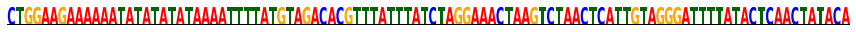

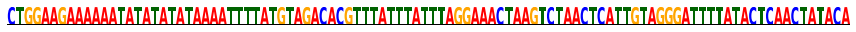

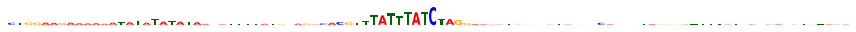

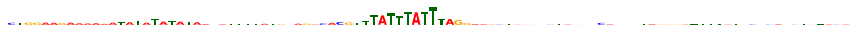

In [5]:
#Example 'chr1_52818188_G_A', Saluki

snp_id = 'chr1_52818188_G_A'

ref_seq = utr5 + orf + df.query("snp_id == 'chr1_52818188_G_A' and tissue_type == 'Lung' and gene_id == 'CC2D1B.8'").iloc[0]['seq'][3:]
var_seq = utr5 + orf + df.query("snp_id == 'chr1_52818188_G_A' and tissue_type == 'Lung' and gene_id == 'CC2D1B.8'").iloc[0]['seq_var'][3:]

snv_pos = -1
for j in range(len(ref_seq)) :
    if ref_seq[j] != var_seq[j] :
        snv_pos = j
        break

print(ref_seq[snv_pos-50:snv_pos+50+1])
print(var_seq[snv_pos-50:snv_pos+50+1])
print(snv_pos)

ref_onehot = np.zeros((1,MAXLEN,6))

ref_onehot[0,0:len(ref_seq),0:4] = dna_io.dna_1hot(ref_seq)
ref_onehot[0,0:len(coding),4] = coding

ref_pred = seqnn_model.predict(ref_onehot, batch_size=1)[0, 0]
ref_scores, _ = _ism(seqnn_model, ref_onehot, seq_start=snv_pos-50, seq_end=snv_pos+50+1, n_out=1)

ref_scores = ref_scores[0, 0, :, :4]

print("ref_pred = " + str(round(ref_pred, 3)))
print("ref_scores.shape = " + str(ref_scores.shape))

var_onehot = np.zeros((1,MAXLEN,6))

var_onehot[0,0:len(var_seq),0:4] = dna_io.dna_1hot(var_seq)
var_onehot[0,0:len(coding),4] = coding

var_pred = seqnn_model.predict(var_onehot, batch_size=1)[0, 0]
var_scores, _ = _ism(seqnn_model, var_onehot, seq_start=snv_pos-50, seq_end=snv_pos+50+1, n_out=1)

var_scores = var_scores[0, 0, :, :4]

print("var_pred = " + str(round(var_pred, 3)))
print("var_scores.shape = " + str(var_scores.shape))

delta_pred = var_pred - ref_pred
delta_scores = var_scores - ref_scores

print("")
print("delta_pred = " + str(round(delta_pred, 3)))
print("delta_scores.shape = " + str(delta_scores.shape))

#Plot ISM scores

fig_name = "gtex_snp_" + str(snp_id) + "_saluki"

plot_dna_logo(ref_onehot[0, snv_pos-50:snv_pos+50+1, :4], sequence_template="$"*100, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_ref")
plot_dna_logo(var_onehot[0, snv_pos-50:snv_pos+50+1, :4], sequence_template="$"*100, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_var")

plot_importance_scores(np.abs(delta_scores).T, (ref_seq[snv_pos-50:snv_pos+50+1] + "T" * 100)[:100], sequence_template="$"*100, score_norm=True, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_ref_scores")
plot_importance_scores(np.abs(delta_scores).T, (var_seq[snv_pos-50:snv_pos+50+1] + "T" * 100)[:100], sequence_template="$"*100, score_norm=True, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_var_scores")


CTGGAAGAAAAAATATATATATAAAATTTTATGTAGACACGTTTATTTATCTAGGAAACTAAGTCTAACTCATTGTAGGGATTTTATACTCAACTATACAG
CTGGAAGAAAAAATATATATATAAAATTTTATGTAGACACGTTTATTTATTTAGGAAACTAAGTCTAACTCATTGTAGGGATTTTATACTCAACTATACAG
101
ref_pred = -3.066
ref_scores.shape = (101, 4)
var_pred = -2.799
var_scores.shape = (101, 4)

delta_pred = 0.267
delta_scores.shape = (101, 4)


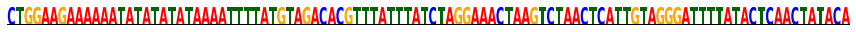

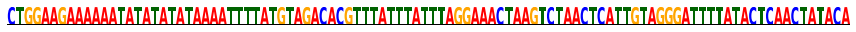

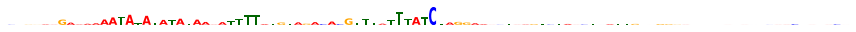

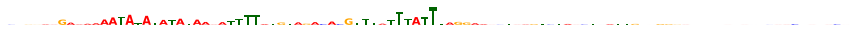

In [19]:
#Example 'chr1_52818188_G_A', APARENT2

from basenji import dna_io

snp_id = 'chr1_52818188_G_A'

ref_seq = "GAAGGTTGGATCTTGGGTTTGGTCTACCCACCCAAGAGAAAAGACTGTTAACTGGAAGAAAAAATATATATATAAAATTTTATGTAGACACGTTTATTTATCTAGGAAACTAAGTCTAACTCATTGTAGGGATTTTATACTCAACTATACAGAGTATCCACCAAAGTCCTAATCTAAAGTCCTGCTCCCTGTCACTTTTTAAAAG"
var_seq = "GAAGGTTGGATCTTGGGTTTGGTCTACCCACCCAAGAGAAAAGACTGTTAACTGGAAGAAAAAATATATATATAAAATTTTATGTAGACACGTTTATTTATTTAGGAAACTAAGTCTAACTCATTGTAGGGATTTTATACTCAACTATACAGAGTATCCACCAAAGTCCTAATCTAAAGTCCTGCTCCCTGTCACTTTTTAAAAG"

snv_pos = -1
for j in range(len(ref_seq)) :
    if ref_seq[j] != var_seq[j] :
        snv_pos = j
        break

print(ref_seq[snv_pos-50:snv_pos+50+1])
print(var_seq[snv_pos-50:snv_pos+50+1])
print(snv_pos)

ref_onehot = np.zeros((1, 205, 4))
ref_l = np.zeros((1, 13))
ref_l[0, 11] = 1.
ref_d = np.zeros((1, 1))

ref_onehot[0, ...] = dna_io.dna_1hot(ref_seq)

ref_pred = aparent.predict([ref_onehot, ref_l, ref_d], batch_size=32)[0, 0]
ref_scores, _ = _ism_aparent(aparent, ref_onehot, ref_l, ref_d, seq_start=snv_pos-50, seq_end=snv_pos+50+1, n_out=1)

ref_scores = ref_scores[0, 0, :, :4]

print("ref_pred = " + str(round(ref_pred, 3)))
print("ref_scores.shape = " + str(ref_scores.shape))

var_onehot = np.zeros((1, 205, 4))
var_l = np.zeros((1, 13))
var_l[0, 11] = 1.
var_d = np.zeros((1, 1))

var_onehot[0, ...] = dna_io.dna_1hot(var_seq)

var_pred = aparent.predict([var_onehot, var_l, var_d], batch_size=32)[0, 0]
var_scores, _ = _ism_aparent(aparent, var_onehot, var_l, var_d, seq_start=snv_pos-50, seq_end=snv_pos+50+1, n_out=1)

var_scores = var_scores[0, 0, :, :4]

print("var_pred = " + str(round(var_pred, 3)))
print("var_scores.shape = " + str(var_scores.shape))

delta_pred = var_pred - ref_pred
delta_scores = var_scores - ref_scores

print("")
print("delta_pred = " + str(round(delta_pred, 3)))
print("delta_scores.shape = " + str(delta_scores.shape))

#Plot ISM scores

fig_name = "gtex_snp_" + str(snp_id) + "_aparent"

plot_dna_logo(ref_onehot[0, snv_pos-50:snv_pos+50+1, :4], sequence_template="$"*100, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_ref")
plot_dna_logo(var_onehot[0, snv_pos-50:snv_pos+50+1, :4], sequence_template="$"*100, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_var")

plot_importance_scores(np.abs(delta_scores).T, (ref_seq[snv_pos-50:snv_pos+50+1] + "T" * 100)[:100], sequence_template="$"*100, score_norm=True, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_ref_scores")
plot_importance_scores(np.abs(delta_scores).T, (var_seq[snv_pos-50:snv_pos+50+1] + "T" * 100)[:100], sequence_template="$"*100, score_norm=True, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_var_scores")


CCCTGCACTTGACCACCAAAGCAATCTCTAAGCTTATAAAGGAGAAACATATATATATGGGGTTTTTTGGAGTAAAGGAAAATTCTAAGAT
CCCTGCACTTGACCACCAAAGCAATCTCTAAGCTTATAAAGGAGAAACATGTATATATGGGGTTTTTTGGAGTAAAGGAAAATTCTAAGAT
2082
ref_pred = 0.135
ref_scores.shape = (101, 4)
var_pred = 0.079
var_scores.shape = (101, 4)

delta_pred = -0.057
delta_scores.shape = (101, 4)


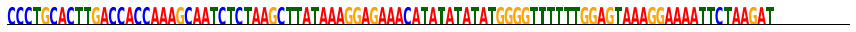

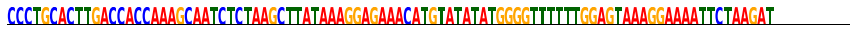

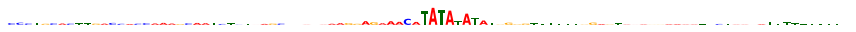

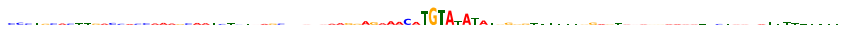

In [6]:
#Example 'chr16_420907_T_C', Saluki

snp_id = 'chr16_420907_T_C'

ref_seq = utr5 + orf + df.query("snp_id == 'chr16_420907_T_C' and tissue_type == 'Brain_Anterior_cingulate_cortex_BA24' and gene_id == 'TMEM8A.3'").iloc[0]['seq'][3:]
var_seq = utr5 + orf + df.query("snp_id == 'chr16_420907_T_C' and tissue_type == 'Brain_Anterior_cingulate_cortex_BA24' and gene_id == 'TMEM8A.3'").iloc[0]['seq_var'][3:]

snv_pos = -1
for j in range(len(ref_seq)) :
    if ref_seq[j] != var_seq[j] :
        snv_pos = j
        break

print(ref_seq[snv_pos-50:snv_pos+50+1])
print(var_seq[snv_pos-50:snv_pos+50+1])
print(snv_pos)

ref_onehot = np.zeros((1,MAXLEN,6))

ref_onehot[0,0:len(ref_seq),0:4] = dna_io.dna_1hot(ref_seq)
ref_onehot[0,0:len(coding),4] = coding

ref_pred = seqnn_model.predict(ref_onehot, batch_size=1)[0, 0]
ref_scores, _ = _ism(seqnn_model, ref_onehot, seq_start=snv_pos-50, seq_end=snv_pos+50+1, n_out=1)

ref_scores = ref_scores[0, 0, :, :4]

print("ref_pred = " + str(round(ref_pred, 3)))
print("ref_scores.shape = " + str(ref_scores.shape))

var_onehot = np.zeros((1,MAXLEN,6))

var_onehot[0,0:len(var_seq),0:4] = dna_io.dna_1hot(var_seq)
var_onehot[0,0:len(coding),4] = coding

var_pred = seqnn_model.predict(var_onehot, batch_size=1)[0, 0]
var_scores, _ = _ism(seqnn_model, var_onehot, seq_start=snv_pos-50, seq_end=snv_pos+50+1, n_out=1)

var_scores = var_scores[0, 0, :, :4]

print("var_pred = " + str(round(var_pred, 3)))
print("var_scores.shape = " + str(var_scores.shape))

delta_pred = var_pred - ref_pred
delta_scores = var_scores - ref_scores

print("")
print("delta_pred = " + str(round(delta_pred, 3)))
print("delta_scores.shape = " + str(delta_scores.shape))

#Plot ISM scores

fig_name = "gtex_snp_" + str(snp_id) + "_saluki"

plot_dna_logo(ref_onehot[0, snv_pos-50:snv_pos+50+1, :4], sequence_template="$"*100, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_ref")
plot_dna_logo(var_onehot[0, snv_pos-50:snv_pos+50+1, :4], sequence_template="$"*100, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_var")

plot_importance_scores(np.abs(delta_scores).T, (ref_seq[snv_pos-50:snv_pos+50+1] + "T" * 100)[:100], sequence_template="$"*100, score_norm=True, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_ref_scores")
plot_importance_scores(np.abs(delta_scores).T, (var_seq[snv_pos-50:snv_pos+50+1] + "T" * 100)[:100], sequence_template="$"*100, score_norm=True, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_var_scores")


CCCTGCACTTGACCACCAAAGCAATCTCTAAGCTTATAAAGGAGAAACATATATATATGGGGTTTTTTGGAGTAAAGGAAAATTCTAAGATATTAAGACAT
CCCTGCACTTGACCACCAAAGCAATCTCTAAGCTTATAAAGGAGAAACATGTATATATGGGGTTTTTTGGAGTAAAGGAAAATTCTAAGATATTAAGACAT
50
ref_pred = -3.952
ref_scores.shape = (101, 4)
var_pred = -3.029
var_scores.shape = (101, 4)

delta_pred = 0.923
delta_scores.shape = (101, 4)


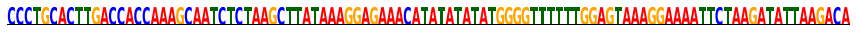

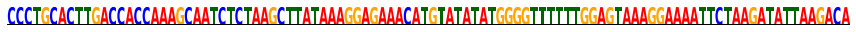

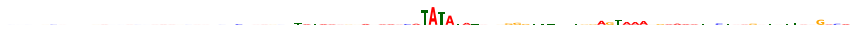

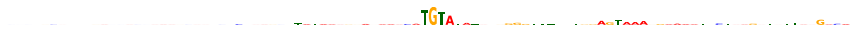

In [20]:
#Example 'chr16_420907_T_C', APARENT2

from basenji import dna_io

snp_id = 'chr16_420907_T_C'

ref_seq = "CCCTGCACTTGACCACCAAAGCAATCTCTAAGCTTATAAAGGAGAAACATATATATATGGGGTTTTTTGGAGTAAAGGAAAATTCTAAGATATTAAGACATATTTTTATGTAGATCTGATCTATCTGTGTTTGGTGAATTTAATATTCTACATTGATTTTTCAAACTAAACGAGTTTTTACATTTTTTCTGTGCTCCTTCCCGGG"
var_seq = "CCCTGCACTTGACCACCAAAGCAATCTCTAAGCTTATAAAGGAGAAACATGTATATATGGGGTTTTTTGGAGTAAAGGAAAATTCTAAGATATTAAGACATATTTTTATGTAGATCTGATCTATCTGTGTTTGGTGAATTTAATATTCTACATTGATTTTTCAAACTAAACGAGTTTTTACATTTTTTCTGTGCTCCTTCCCGGG"

snv_pos = -1
for j in range(len(ref_seq)) :
    if ref_seq[j] != var_seq[j] :
        snv_pos = j
        break

print(ref_seq[snv_pos-50:snv_pos+50+1])
print(var_seq[snv_pos-50:snv_pos+50+1])
print(snv_pos)

ref_onehot = np.zeros((1, 205, 4))
ref_l = np.zeros((1, 13))
ref_l[0, 11] = 1.
ref_d = np.zeros((1, 1))

ref_onehot[0, ...] = dna_io.dna_1hot(ref_seq)

ref_pred = aparent.predict([ref_onehot, ref_l, ref_d], batch_size=32)[0, 0]
ref_scores, _ = _ism_aparent(aparent, ref_onehot, ref_l, ref_d, seq_start=snv_pos-50, seq_end=snv_pos+50+1, n_out=1)

ref_scores = ref_scores[0, 0, :, :4]

print("ref_pred = " + str(round(ref_pred, 3)))
print("ref_scores.shape = " + str(ref_scores.shape))

var_onehot = np.zeros((1, 205, 4))
var_l = np.zeros((1, 13))
var_l[0, 11] = 1.
var_d = np.zeros((1, 1))

var_onehot[0, ...] = dna_io.dna_1hot(var_seq)

var_pred = aparent.predict([var_onehot, var_l, var_d], batch_size=32)[0, 0]
var_scores, _ = _ism_aparent(aparent, var_onehot, var_l, var_d, seq_start=snv_pos-50, seq_end=snv_pos+50+1, n_out=1)

var_scores = var_scores[0, 0, :, :4]

print("var_pred = " + str(round(var_pred, 3)))
print("var_scores.shape = " + str(var_scores.shape))

delta_pred = var_pred - ref_pred
delta_scores = var_scores - ref_scores

print("")
print("delta_pred = " + str(round(delta_pred, 3)))
print("delta_scores.shape = " + str(delta_scores.shape))

#Plot ISM scores

fig_name = "gtex_snp_" + str(snp_id) + "_aparent"

plot_dna_logo(ref_onehot[0, snv_pos-50:snv_pos+50+1, :4], sequence_template="$"*100, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_ref")
plot_dna_logo(var_onehot[0, snv_pos-50:snv_pos+50+1, :4], sequence_template="$"*100, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_var")

plot_importance_scores(np.abs(delta_scores).T, (ref_seq[snv_pos-50:snv_pos+50+1] + "T" * 100)[:100], sequence_template="$"*100, score_norm=True, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_ref_scores")
plot_importance_scores(np.abs(delta_scores).T, (var_seq[snv_pos-50:snv_pos+50+1] + "T" * 100)[:100], sequence_template="$"*100, score_norm=True, figsize=(12, 0.55), plot_start=0, plot_end=100, save_figs=True, fig_name=fig_name + "_var_scores")
